In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import seaborn as sns
import scipy
import plotly.graph_objs as go
import plotly 
import plotly.figure_factory as ff
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
import missingno as msno

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/data.csv')


In [4]:
df.head()

,Unnamed: 0,index,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,0,0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,1,1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2,2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,3,3,2011-07-01,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0
4,4,4,2012-08-07,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0


In [5]:
df.shape

(20000, 13)

# EDA:


# Statistique descriptive:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  20000 non-null  int64  
 1   index       20000 non-null  int64  
 2   date        19909 non-null  object 
 3   cheveux     19897 non-null  object 
 4   age         19909 non-null  float64
 5   exp         19904 non-null  float64
 6   salaire     19905 non-null  float64
 7   sexe        19900 non-null  object 
 8   diplome     19890 non-null  object 
 9   specialite  19907 non-null  object 
 10  note        19886 non-null  float64
 11  dispo       19894 non-null  object 
 12  embauche    20000 non-null  int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 2.0+ MB


On a un jeu de donnée qui contient 11 variables dont 6 sont qualitatives et 5 quantitatives

verifions la nature de notre problème :

In [7]:
a = df['embauche'].value_counts()


D'une première vue on peut voir que la classe 0 (non embauche) est majoritaire devant la classe 1, c'est ce qu'on appalle umbalanced data

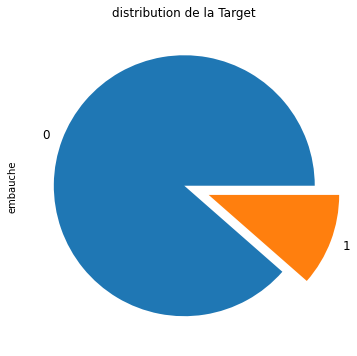

In [8]:
a.plot(kind='pie',title= 'distribution de la Target', legend = False, figsize=(12,6), fontsize=12,explode = [0, 0.2])

In [9]:
#  categorical data
target_columns = ['embauche']
features = [col for col in df.columns if col not in target_columns]

categorical_features = []
numerical_features = []

for col in features :
  if np.issubdtype('O', df[col].dtype):
    categorical_features.append(col)  
  else:
    numerical_features.append(col)

In [10]:
numerical_features

['Unnamed: 0', 'index', 'age', 'exp', 'salaire', 'note']

In [11]:
categorical_features

['date', 'cheveux', 'sexe', 'diplome', 'specialite', 'dispo']

In [12]:
# we chack let's see if we have a misspelled values in our categorical features
for i in range(len(categorical_features)):
  print(categorical_features[i])
  print( df[categorical_features[i]].value_counts())
  print('+++++++++++++++++++++++++++')

date
2012-02-03    24
2013-06-17    23
2013-04-11    22
2011-09-03    21
2014-08-16    21
              ..
2010-08-04     3
2012-03-23     3
2012-06-28     3
2011-03-02     2
2014-08-26     1
Name: date, Length: 1826, dtype: int64
+++++++++++++++++++++++++++
cheveux
chatain    6022
brun       5991
blond      5929
roux       1955
Name: cheveux, dtype: int64
+++++++++++++++++++++++++++
sexe
M    11889
F     8011
Name: sexe, dtype: int64
+++++++++++++++++++++++++++
diplome
master      7513
licence     7377
doctorat    2547
bac         2453
Name: diplome, dtype: int64
+++++++++++++++++++++++++++
specialite
geologie       10028
forage          4340
detective       4155
archeologie     1384
Name: specialite, dtype: int64
+++++++++++++++++++++++++++
dispo
non    11848
oui     8046
Name: dispo, dtype: int64
+++++++++++++++++++++++++++


## Les valeurs abberantes:

Nous affichons les box plots des différentes variables:

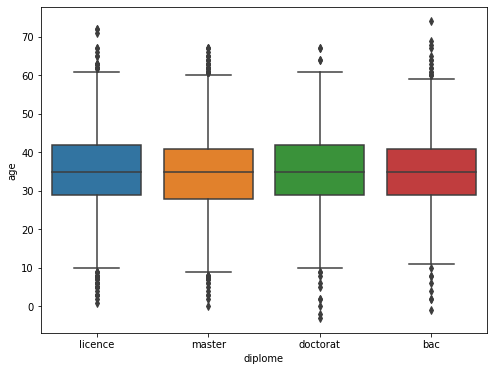

In [13]:
plt.figure(figsize=(8,6))
sns.boxplot(x='diplome',
            y='age',
            data=df)

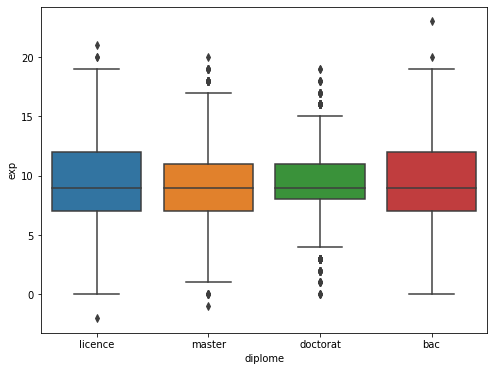

In [14]:
plt.figure(figsize=(8,6))
sns.boxplot(x='diplome',
            y='exp',
            data=df)

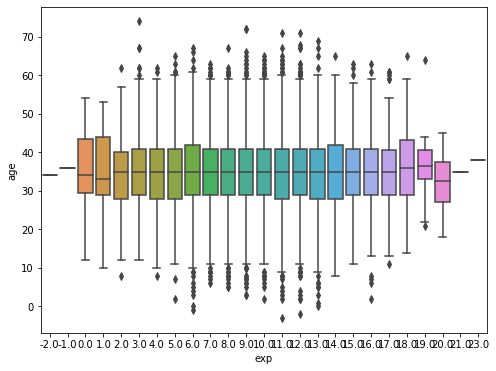

In [15]:
plt.figure(figsize=(8,6))
sns.boxplot(x='exp',
            y='age',
            data=df)

### Les valeurs abberantes de la variable "age" : 
Nous supposons que l'age minimal de travail chez cette entreprise est est 18 ans et l'age de la retraite est de 65 ans


In [16]:
df.loc[(df['age'] >= 65), 'age'] = round(df['age'].mean(), 0)
df.loc[(df['age'] < 18), 'age'] = round(df['age'].mean(), 0) 


### Les valeurs abberantes de la variable "Diplome" : 
Nous traitons cette variable en fonction de l'age:
- diplome bac : age 18 ans 
- license --> 21 ans 
- master --> 23 ans
- doctorat --> 27 ans


In [17]:
df.loc[(df['diplome'] == "bac"), 'age'] = 18 
df.loc[(df['diplome'] == "licence"), 'age'] = 21 
df.loc[(df['diplome'] == "master"), 'age'] = 23 
df.loc[(df['diplome'] == "doctorat"), 'age'] = 27 

### Les valeurs abberantes de la variable "Exp" : 
Sur des observations ou l'expérience dépasse l'âge, cette dernière sera remplacée par la moyenne de l'expérience
Nous remplaçons l'expérience par la moyenne quand elle dépasse l'age et quand elle est inférieur à zéro.


In [18]:
df.loc[(df['exp'] < 0), 'exp'] = round(df['exp'].mean(), 0) 
df.loc[(df['exp'] > df['age']),'exp'] = round(df['exp'].mean(),0) 


Nous remplaçons la note par 100 quand elle est supérieure à 100 


In [19]:
df.loc[(df['note'] > 100), 'note'] = 100 


## Imputation des valeurs manquantes:

In [20]:
numerical_features.remove('index')
numerical_features.remove('Unnamed: 0')

In [21]:
#the number of missing values for each variable
df[numerical_features].isnull().sum()

age          0
exp         96
salaire     95
note       114
dtype: int64

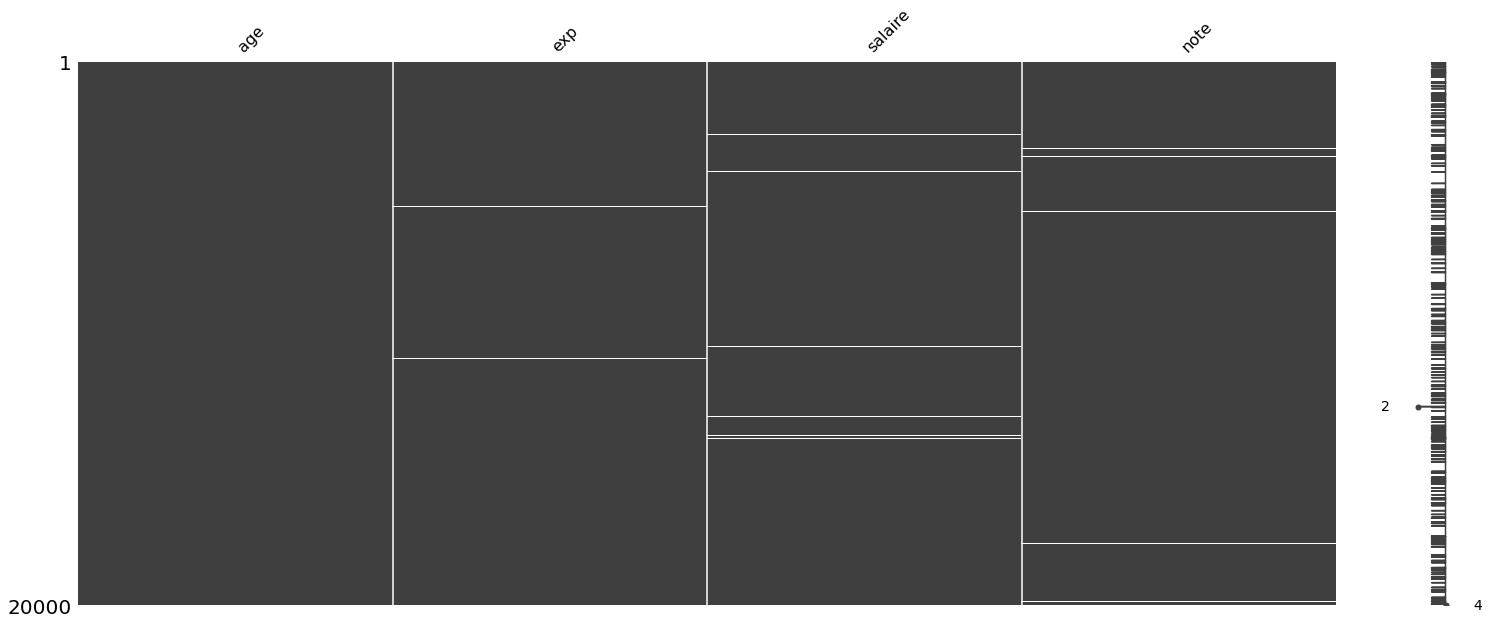

In [22]:
# plot of the position of missing values for each feature
msno.matrix(df[numerical_features])


On peut voir qu'un valeur manquante d'une variabe n'est pas associée ç une autre variable ou avec la variable 'embauche'. c'est à dire on n'a aucune dépendance entre les valeurs manquantes (values missing Completely at Random) d'ou on peut les remplacer par  la moyenne.

In [23]:
#Variables Numériques
df[numerical_features]= df[numerical_features].astype(np.float32)
df[numerical_features] = df[numerical_features].fillna(round(df[numerical_features].mean(), 0))


In [24]:
#the number of missing values for each variable
df[categorical_features].isnull().sum()

date           91
cheveux       103
sexe          100
diplome       110
specialite     93
dispo         106
dtype: int64

In [25]:
#Variables quali
df[categorical_features ]= df[categorical_features ].astype('category')
df[categorical_features ] = df[categorical_features ].fillna(df[categorical_features ].mode().iloc[0])


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Unnamed: 0  20000 non-null  int64   
 1   index       20000 non-null  int64   
 2   date        20000 non-null  category
 3   cheveux     20000 non-null  category
 4   age         20000 non-null  float32 
 5   exp         20000 non-null  float32 
 6   salaire     20000 non-null  float32 
 7   sexe        20000 non-null  category
 8   diplome     20000 non-null  category
 9   specialite  20000 non-null  category
 10  note        20000 non-null  float32 
 11  dispo       20000 non-null  category
 12  embauche    20000 non-null  int64   
dtypes: category(6), float32(4), int64(3)
memory usage: 1013.1 KB


##   Création de nouvelles features numériques à partir de la date

In [27]:
df['date'] = pd.to_datetime(df['date'],format="%Y-%m-%d")
df['year']=  df['date'].dt.year
df['month']=  df['date'].dt.month
df['day']=  df['date'].dt.day

## Création de nouvelles Variables catégoriques

In [28]:
df['q_exp'] = pd.qcut(df['exp'],q=3,precision=0)
df['q_age'] = pd.qcut(df['age'], q=3,precision=0)
df['q_note'] = pd.qcut(df['note'],q=4,precision=0)
df['q_salaire'] = pd.qcut(df['salaire'],q=5,precision=0)

In [29]:
numerical_features = ["age","exp","salaire","note","year","month","day"]
#df[numerical_features]= df[numerical_features].astype(np.float32)

In [30]:
df.head()

,Unnamed: 0,index,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche,year,month,day,q_exp,q_age,q_note,q_salaire
0,0,0,2012-06-02,roux,21.0,9.0,26803.0,F,licence,geologie,97.080002,non,0,2012,6,2,"(8.0, 11.0]","(17.0, 21.0]","(87.0, 100.0]","(14127.0, 30776.0]"
1,1,1,2011-04-21,blond,21.0,13.0,38166.0,M,licence,forage,63.860001,non,0,2011,4,21,"(11.0, 21.0]","(17.0, 21.0]","(64.0, 75.0]","(36208.0, 39160.0]"
2,2,2,2012-09-07,blond,21.0,13.0,35207.0,M,licence,geologie,78.500000,non,0,2012,9,7,"(11.0, 21.0]","(17.0, 21.0]","(75.0, 87.0]","(33736.0, 36208.0]"
3,3,3,2011-07-01,brun,21.0,12.0,32442.0,M,licence,geologie,45.090000,non,0,2011,7,1,"(11.0, 21.0]","(17.0, 21.0]","(8.0, 64.0]","(30776.0, 33736.0]"
4,4,4,2012-08-07,roux,21.0,6.0,28533.0,F,licence,detective,81.910004,non,0,2012,8,7,"(-1.0, 8.0]","(17.0, 21.0]","(75.0, 87.0]","(14127.0, 30776.0]"


In [31]:
categorical_features

['date', 'cheveux', 'sexe', 'diplome', 'specialite', 'dispo']

In [32]:
FEATURES = numerical_features + categorical_features + ["q_exp","q_age","q_note",'q_salaire']
TARGET = "embauche"


In [33]:
FEATURES

['age',
 'exp',
 'salaire',
 'note',
 'year',
 'month',
 'day',
 'date',
 'cheveux',
 'sexe',
 'diplome',
 'specialite',
 'dispo',
 'q_exp',
 'q_age',
 'q_note',
 'q_salaire']

## distribution des variables en fonction de notre target " embauche":

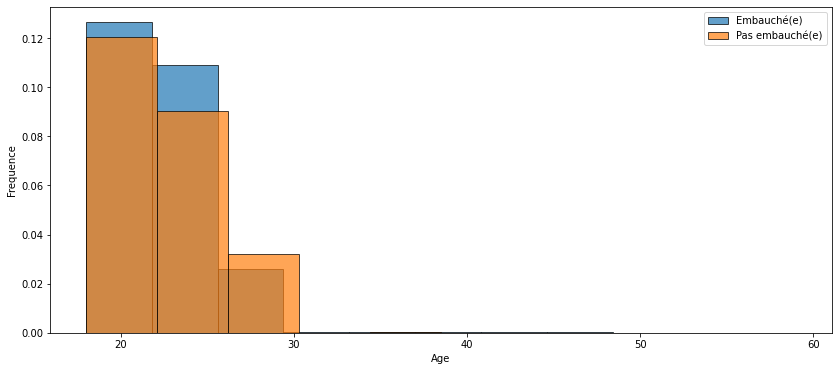

In [34]:
plt.figure(figsize=(14,6))
plt.hist(df[df["embauche"]==1]["age"], edgecolor="k",density=True, alpha=0.7, label = "Embauché(e)")
plt.hist(df[df["embauche"]==0]["age"], edgecolor="k",density=True, alpha=0.7, label = "Pas embauché(e)")
plt.xlabel("Age")
plt.ylabel("Frequence")
plt.legend()
plt.show()

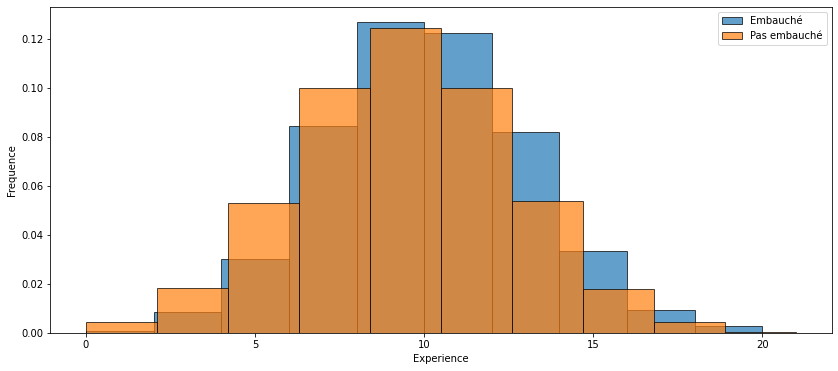

In [35]:
plt.figure(figsize=(14,6))
plt.hist(df[df["embauche"]==1]["exp"], edgecolor="k",density=True, alpha=0.7, label = "Embauché")
plt.hist(df[df["embauche"]==0]["exp"], edgecolor="k",density=True, alpha=0.7, label = "Pas embauché")
plt.xlabel("Experience")
plt.ylabel("Frequence")
plt.legend()
plt.show()

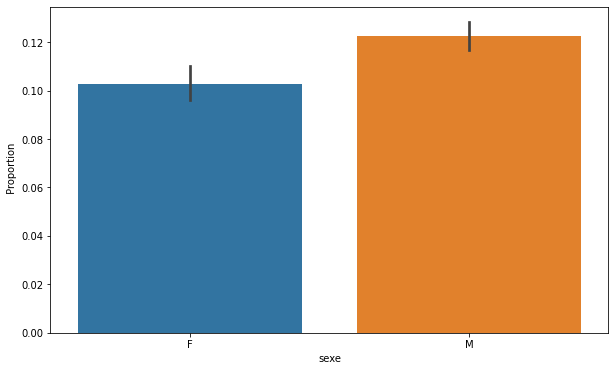

In [36]:
from matplotlib.pyplot import figure
figure(figsize=(10,6))
sns.barplot(x='sexe',y="embauche", data=df)
plt.ylabel(" Proportion")
plt.show()


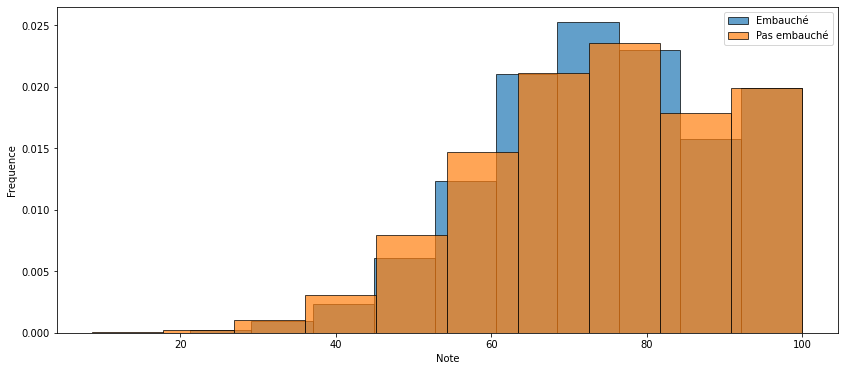

In [38]:
plt.figure(figsize=(14,6))
plt.hist(df[df["embauche"]==1]["note"], edgecolor="k",density=True, alpha=0.7, label = "Embauché")
plt.hist(df[df["embauche"]==0]["note"], edgecolor="k",density=True, alpha=0.7, label = "Pas embauché")
plt.xlabel("Note")
plt.ylabel("Frequence")
plt.legend()
plt.show()

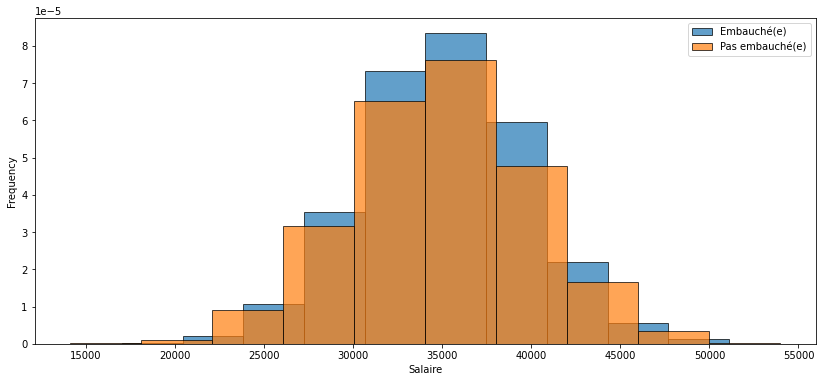

In [39]:
plt.figure(figsize=(14,6))
plt.hist(df[df["embauche"]==1]["salaire"], edgecolor="k",density=True, alpha=0.7, label = "Embauché(e)")
plt.hist(df[df["embauche"]==0]["salaire"], edgecolor="k",density=True, alpha=0.7, label = "Pas embauché(e)")
plt.xlabel("Salaire")
plt.ylabel("Frequency")
plt.legend()
plt.show()

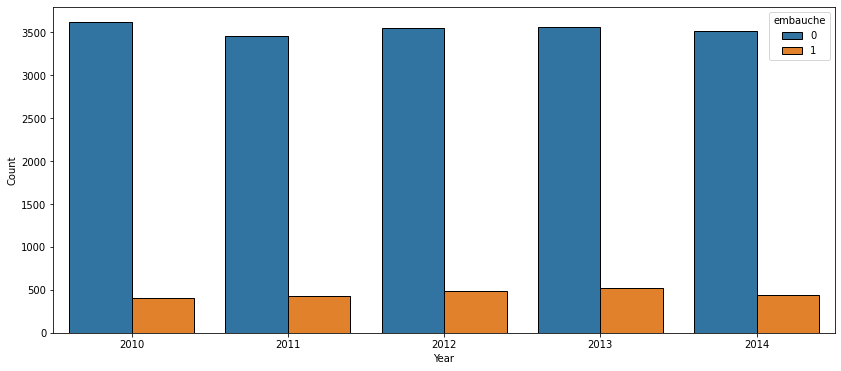

In [40]:
plt.figure(figsize=(14,6))
sns.countplot(data=df, x="year",hue="embauche", edgecolor="k")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

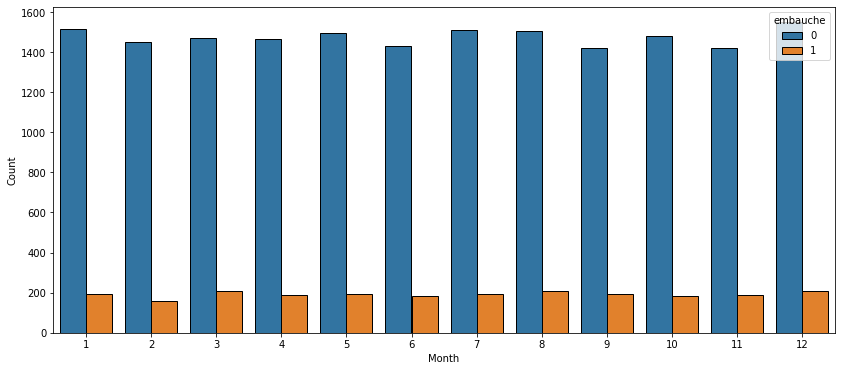

In [41]:
plt.figure(figsize=(14,6))
sns.countplot(data=df, x="month",hue="embauche", edgecolor="k")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()


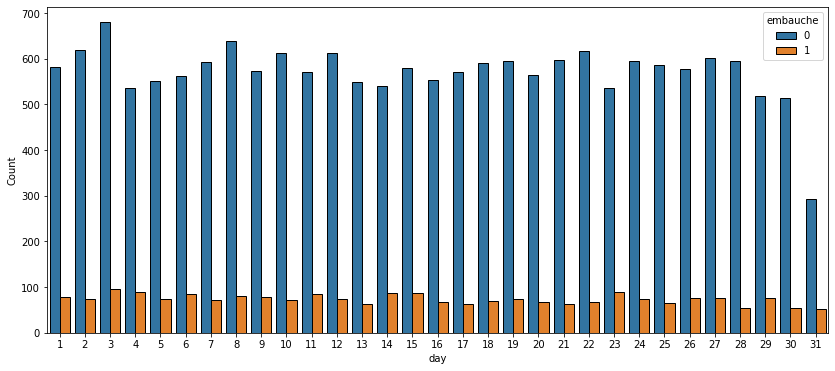

In [42]:
plt.figure(figsize=(14,6))
sns.countplot(data=df, x="day",hue="embauche", edgecolor="k")
plt.xlabel("day")
plt.ylabel("Count")
plt.show()

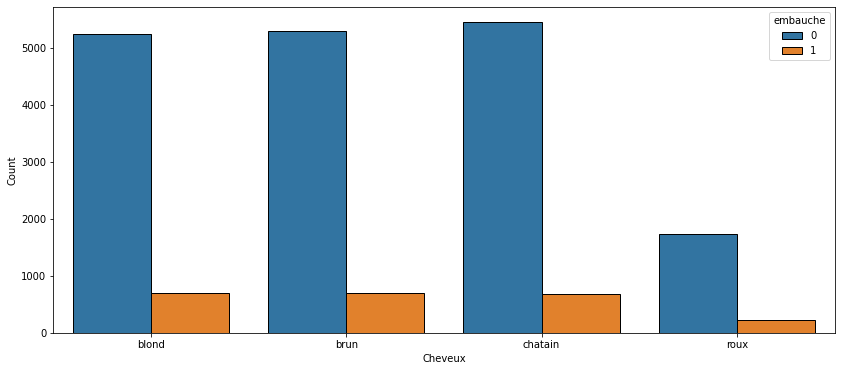

In [43]:
plt.figure(figsize=(14,6))
sns.countplot(data=df, x="cheveux",hue="embauche", edgecolor="k")
plt.xlabel("Cheveux")
plt.ylabel("Count")
plt.show()

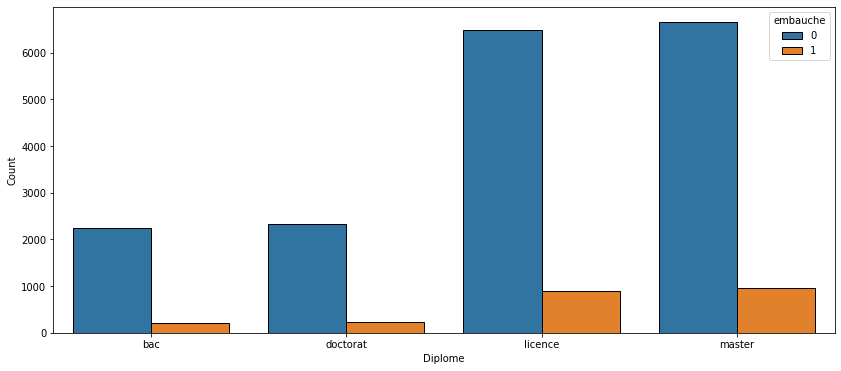

In [44]:
plt.figure(figsize=(14,6))
sns.countplot(data=df, x="diplome",hue="embauche", edgecolor="k")
plt.xlabel("Diplome")
plt.ylabel("Count")
plt.show()

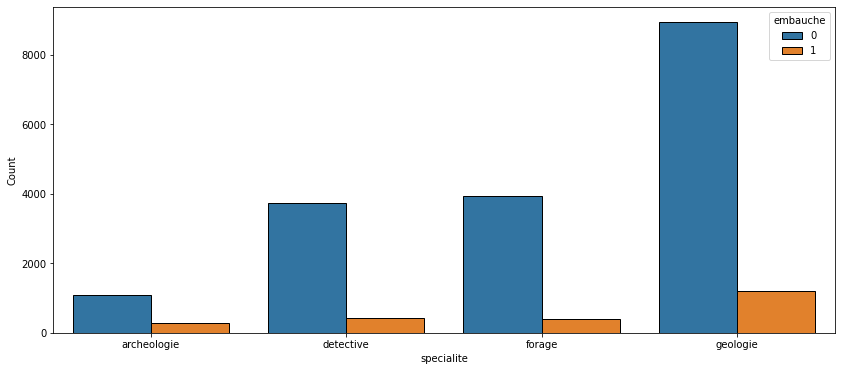

In [45]:
plt.figure(figsize=(14,6))
sns.countplot(data=df, x="specialite",hue="embauche", edgecolor="k")
plt.xlabel("specialite")
plt.ylabel("Count")
plt.show()

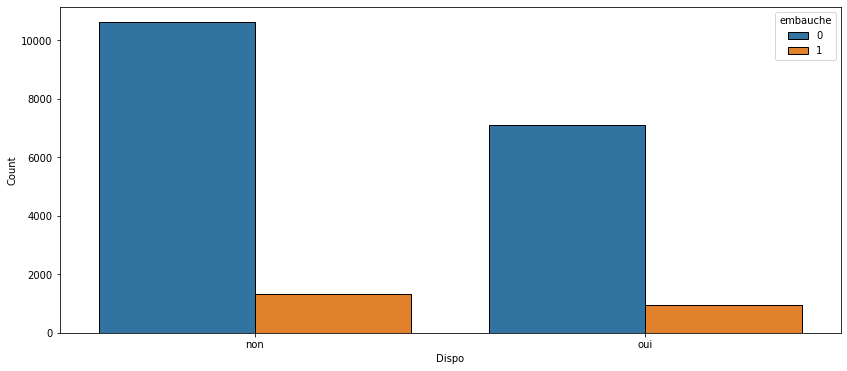

In [46]:
plt.figure(figsize=(14,6))
sns.countplot(data=df, x="dispo",hue="embauche", edgecolor="k")
plt.xlabel("Dispo")
plt.ylabel("Count")
plt.show()

d'aprés les distributions affichées on peut dire que l'age des embauché varie entre 18 et 30 et le taux de refus des candidatures est trés grand pour l'age de 20-23 ans, plus le nombre d'années d'expériences est grand plus le taux d'embauche est grand et aprés 10 ans d'expériences les employés tendent à chercheche la stabilité, c'est le cas aussi pour le salaire.
Le sexe n'influence pas la possibilité d'embauche ccar le pourcentage des embauches est le meme pour les deux "M" et "F"

### 2/- Tests Statistiques: 


## a)- SPECIALITE / SEXE:
- Hypothèse H0 : Pas de relation statistiquement significative

In [47]:
data_forage =df[df["specialite"]=="forage"]
data_geologie = df[df["specialite"]=="geologie"]
data_detective =df[df["specialite"]=="detective"]
data_archeologie =df[df["specialite"]=="archeologie"]
stat, p_value = scipy.stats.kruskal(data_forage["sexe"], data_geologie["sexe"],data_detective["sexe"] ,
                                    data_archeologie["sexe"])

print('Statistics=%.3f, p_value=%.3f' % (stat, p_value))
# interpret
alpha = 0.05
if p_value > alpha:
    print('Même distributions (Hypothèse H0 non rejetée)')
else:
    print('Distributions différentes (Hypothèse H0 rejetée)')

Statistics=2687.315, p_value=0.000
Distributions différentes (Hypothèse H0 rejetée)


## b)- CHEVEUX / SALAIRE
- Hypothèse H0 : Pas de relation statistiquement significative

In [48]:
data_blond =df[df["cheveux"]=="blond"]
data_brun = df[df["cheveux"]=="brun"]
data_roux =df[df["cheveux"]=="roux"]
data_chatain =df[df["cheveux"]=="chatain"]
stat, p_value = scipy.stats.kruskal(data_blond["salaire"], data_brun["salaire"],data_roux["salaire"] ,data_chatain["salaire"])

print('Statistics=%.3f, p_value=%.3f' % (stat, p_value))
alpha = 0.05
if p_value > alpha:
    print('Même distributions (Hypothèse H0 non rejetée)')
else:
    print('Distributions différentes (Hypothèse H0 rejetée)')

Statistics=82.139, p_value=0.000
Distributions différentes (Hypothèse H0 rejetée)


## b)- EXP / NOTE


,exp,note
exp,1.000000,-0.013044
note,-0.013044,1.000000


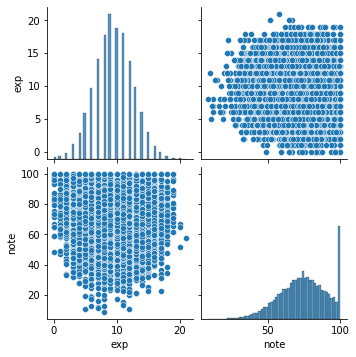

In [49]:
#On étudie la corrélation
sns.pairplot(df[['exp','note']])
df[['exp','note']].corr()

,age,exp,salaire,note,year,month,day
age,1.000000,-0.000723,-0.337197,0.450506,0.005683,-0.000706,-0.000237
exp,-0.000723,1.000000,0.009493,-0.013044,-0.006086,-0.003705,-0.015203
salaire,-0.337197,0.009493,1.000000,-0.440194,-0.009324,-0.004957,-0.000824
note,0.450506,-0.013044,-0.440194,1.000000,-0.001229,-0.010100,0.012962
year,0.005683,-0.006086,-0.009324,-0.001229,1.000000,0.003397,0.002084
month,-0.000706,-0.003705,-0.004957,-0.010100,0.003397,1.000000,0.021725
day,-0.000237,-0.015203,-0.000824,0.012962,0.002084,0.021725,1.000000


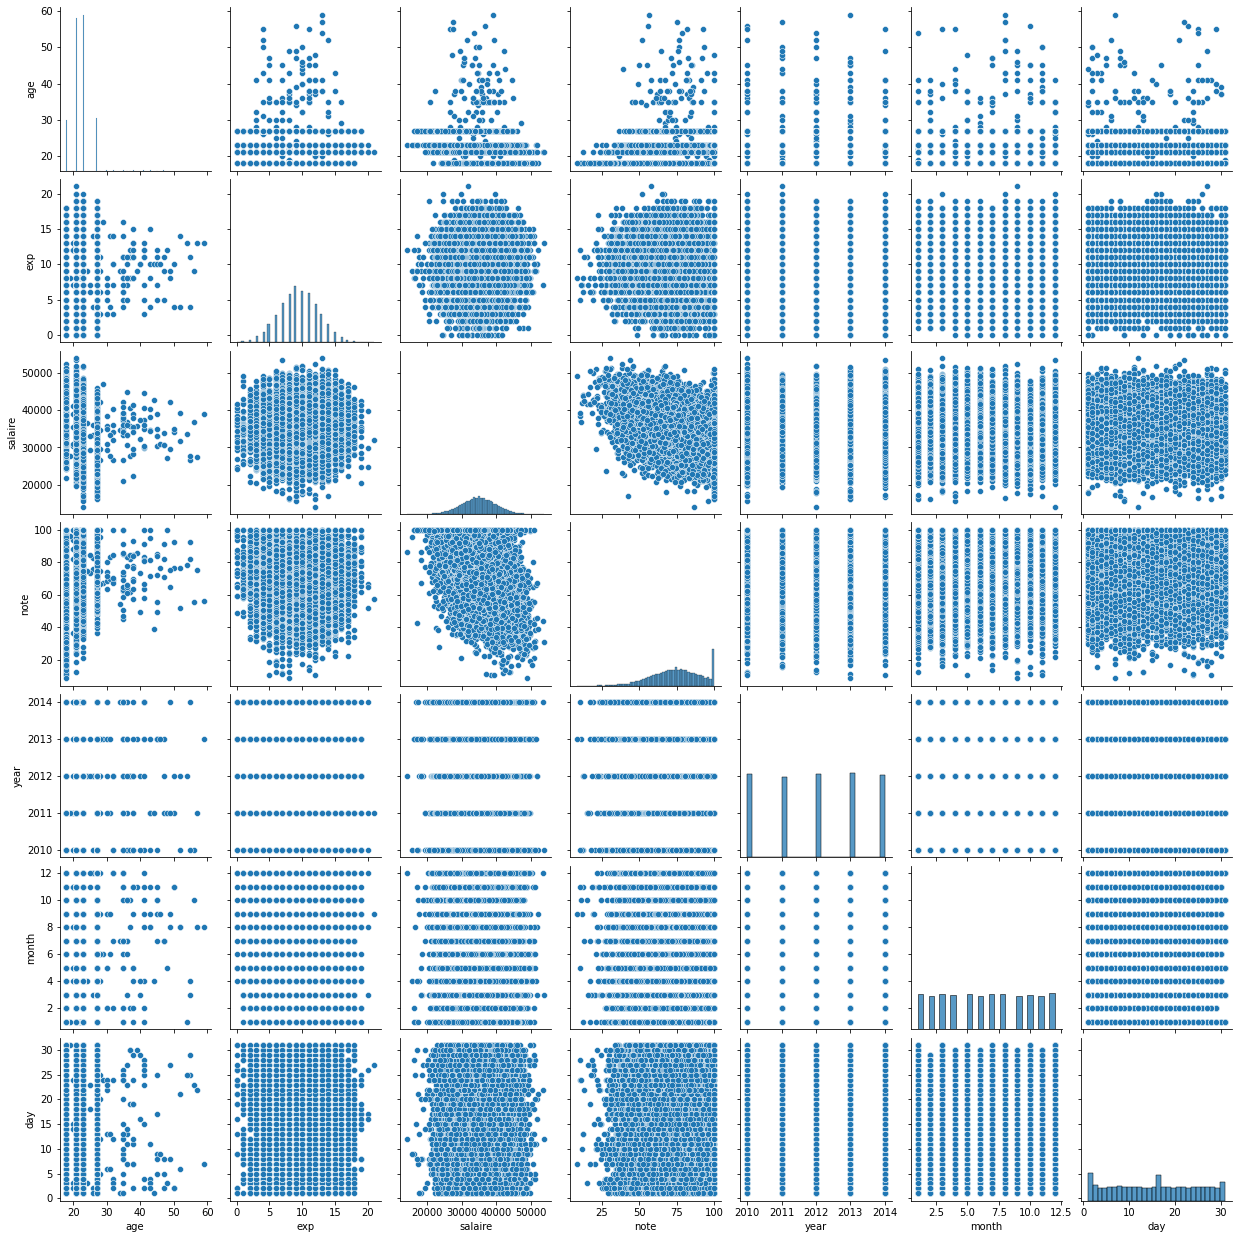

In [50]:
sns.pairplot(df[numerical_features])
df[numerical_features].corr()

Aucune corrélation élevée a été trouvée donc on n'a pas une redondance de l'information

In [51]:
def test_chi_2(QualVar,target,alpha):
    QualVar = pd.DataFrame(QualVar)
    liste_chi2 = []
    liste_chi2_name = []
    # ici on créé le tableau de contingence pour réaliser notre test :
    for i in range(len(list(QualVar.columns))):
        table = pd.crosstab(QualVar[list(QualVar.columns)[i]],QualVar[target])
        stat, p, dof, expected = chi2_contingency(table)
        if p <= alpha:
            liste_chi2.append(i)
        else:
            pass
    for j in liste_chi2:
        liste_chi2_name.append([i.encode('ascii', 'ignore') for i in QualVar.columns][j])
    return liste_chi2_name

Les variables listées ont une p_value < 5% et donc présente une significativité statistique pour expliquer la TARGET

In [52]:
liste_chi2_name = test_chi_2(df,"embauche",0.05)
liste_chi2_name

[b'age',
 b'sexe',
 b'diplome',
 b'specialite',
 b'embauche',
 b'year',
 b'q_age',
 b'q_salaire']

#  PREPROCESSING :

###   Label Encoding

Le choix s'est porté sur le label encoding pour éviter une augumentation de la dimension créée par le One hot encoding par exemple, et ce pour plus de performance lors des Tunnings des hyperparamètres

In [53]:
df_c=df.copy()

In [54]:
label_encoder = preprocessing.LabelEncoder()
df_c[categorical_features]=df[categorical_features].apply(label_encoder.fit_transform)
df_c[["q_exp","q_age","q_note",'q_salaire']] = df[["q_exp","q_age","q_note",'q_salaire']].apply(label_encoder.fit_transform)
df_c[TARGET]=df[TARGET]

###  Transformation du type 

In [55]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  20000 non-null  int64  
 1   index       20000 non-null  int64  
 2   date        20000 non-null  int64  
 3   cheveux     20000 non-null  int64  
 4   age         20000 non-null  float32
 5   exp         20000 non-null  float32
 6   salaire     20000 non-null  float32
 7   sexe        20000 non-null  int64  
 8   diplome     20000 non-null  int64  
 9   specialite  20000 non-null  int64  
 10  note        20000 non-null  float32
 11  dispo       20000 non-null  int64  
 12  embauche    20000 non-null  int64  
 13  year        20000 non-null  int64  
 14  month       20000 non-null  int64  
 15  day         20000 non-null  int64  
 16  q_exp       20000 non-null  int64  
 17  q_age       20000 non-null  int64  
 18  q_note      20000 non-null  int64  
 19  q_salaire   20000 non-nul

In [56]:
df_c['age'] = df_c['age'].astype(np.uint8)
df_c['exp'] = df_c['exp'].astype(np.uint8)
df_c['salaire'] = df_c['salaire'].astype(np.uint8)
df_c['cheveux'] = df_c['cheveux'].astype(np.uint8)
df_c['note'] = df_c['note'].astype(np.float16)
df_c['sexe'] = df_c['sexe'].astype(np.uint8)
df_c['diplome'] = df_c['diplome'].astype(np.uint8)
df_c['specialite'] = df_c['specialite'].astype(np.uint8)
df_c['dispo'] = df_c['dispo'].astype(np.uint8)
df_c['year'] = df_c['year'].astype(np.int16)
df_c['month'] = df_c['month'].astype(np.int16)
df_c['day'] = df_c['day'].astype(np.int16)
df_c['q_exp'] = df_c['q_exp'].astype(np.int16)
df_c['q_age'] = df_c['q_age'].astype(np.int16)
df_c['q_salaire'] = df_c['q_salaire'].astype(np.int16)    
df_c['q_note'] = df_c['q_note'].astype(np.int16) 

###  Train/Test Split

In [57]:
train = df_c.loc[~df_c[TARGET].isna()]

###  Oversampling de la classe minoritaire "embauche = 1" *


Le SMOTETomek procédera à la création de valeurs synthétiques similaires aux vraies valeurs présentes dans le dataset avec une Embauche = 1


In [58]:
from imblearn.combine import SMOTETomek

In [59]:
smotetomek_X = train[FEATURES]
smotetomek_Y = train[TARGET]

In [60]:
print ((smotetomek_Y == 1).sum())
print ((smotetomek_Y == 0).sum())

2292
17708


In [61]:
smote_tomek = SMOTETomek(random_state=68, sampling_strategy=0.99) #La classe 1 sera 99% de la classe 0
X_resampled, y_resampled = smote_tomek.fit_resample(train[FEATURES], train[TARGET])
smotetomek_X = pd.DataFrame(data = X_resampled,columns=FEATURES)
smotetomek_Y = pd.DataFrame(data = y_resampled,columns=['embauche'])

In [62]:
print ((smotetomek_Y['embauche'] == 1).sum())
print ((smotetomek_Y['embauche'] == 0).sum())

17196
17374


In [63]:
data_X = smotetomek_X.copy()
data_Y = smotetomek_Y.copy()

In [64]:
data_X = data_X[FEATURES]
data_Y = data_Y[TARGET]


In [65]:
data = pd.concat([data_X,data_Y], axis= 1)

**Distribution de la target après Oversampling**

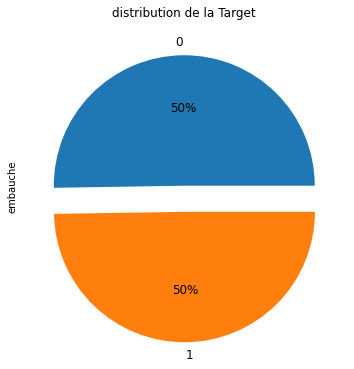

In [66]:
data_Y.value_counts().plot(kind='pie',title= 'distribution de la Target', autopct='%.f%%', legend = False, figsize=(12,6), fontsize=12,explode = [0, 0.2]);

###  Standardisation des données

### Remarque : 

La standardisation des données n'est pas nécessaire quand on utilise des algorithmes d'apprentissage non sensibles à l'amplitude des variables tels que
- La régression logistique
- Le Random Forest
- Les modèles de Gradient boosting

Hors dans ce projet, on utilisera aussi le SVC, DTC & KNN qui eux sont sensibles à l'amplitude des variables

In [67]:
data.describe()

,age,exp,salaire,note,year,month,day,date,cheveux,sexe,diplome,specialite,dispo,q_exp,q_age,q_note,q_salaire,embauche
count,34570.000000,34570.000000,34570.000000,3.457000e+04,34570.000000,34570.000000,34570.000000,34570.000000,34570.000000,34570.000000,34570.000000,34570.000000,34570.000000,34570.000000,34570.000000,34570.000000,34570.000000,34570.000000
mean,22.084756,9.334452,127.299277,inf,2012.023662,6.470755,15.231154,921.956349,1.050362,0.533613,1.932890,1.989876,0.316604,0.744489,0.503789,1.378421,1.831819,0.497426
std,2.462797,2.774678,73.588082,1.484375e+01,1.393927,3.442485,8.288783,518.474570,0.920788,0.498876,0.927751,1.002131,0.465158,0.731509,0.641231,1.072666,1.304494,0.500001
min,18.000000,0.000000,0.000000,8.679688e+00,2010.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,7.000000,64.000000,6.487500e+01,2011.000000,3.000000,8.000000,483.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,22.000000,9.000000,127.000000,7.500000e+01,2012.000000,6.000000,15.000000,921.000000,1.000000,1.000000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000
75%,23.000000,11.000000,190.000000,8.568750e+01,2013.000000,9.000000,22.000000,1365.000000,2.000000,1.000000,3.000000,3.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000
max,59.000000,21.000000,255.000000,1.000000e+02,2014.000000,12.000000,31.000000,1825.000000,3.000000,1.000000,3.000000,3.000000,1.000000,2.000000,2.000000,3.000000,4.000000,1.000000


In [68]:
data.shape

(34570, 18)

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.33, random_state=42)

In [70]:
X_train.shape

(23161, 17)

In [71]:
X_test.shape

(11409, 17)

In [72]:
scaler = StandardScaler()

X_train[FEATURES] = scaler.fit_transform(X_train)
X_test[FEATURES] = scaler.fit_transform(X_test)

# 4. MODELISATION:

- On a un problème d'une classification binaire

- On choisira donc des Algorithmes d'apprentissage supervisé pour CLASSIFICATION

- La comparaison des modèles se fera principalement sur le score AUC

- Le tunning des hyperparamètres se fera avec GridSearchCV.

### Tunning des Hyperparamètres avec GridSearchCV 

In [73]:
import sklearn.metrics as skm

In [74]:
def tunning(param_grid,model,X,Y):    
    GS = GridSearchCV(model, param_grid = param_grid,scoring="roc_auc",
                                  n_jobs = -1,cv = 5, verbose = 1)
    GS2 = GS.fit(X, Y)
    print ("Best Score: {}".format(GS.best_score_)) 
    print ("Best params: {}".format(GS.best_params_)) 
    GS_model = GS2.best_estimator_
    return GS_model


###  Evaluation du modèle 


In [75]:
xgc = XGBClassifier(use_label_encoder=False)

parameters = {'max_depth': [3, 5, 7, 9], 
'n_estimators': [5, 10, 15, 20, 25, 50, 100],
'learning_rate': [0.01, 0.05, 0.1]
              }
xgb = tunning(parameters,xgc, X_train, y_train)


Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best Score: 0.9755857355576218
Best params: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100}


In [76]:
preds1 = xgb.predict(X_test)
print("Tuned XGBOOST results:")
print("Precision: " + str(round(skm.precision_score(y_true=y_test,y_pred=preds1,average='weighted') * 100, 2)) + "%")
print("Recall:    " + str(round(skm.recall_score(y_true=y_test,y_pred=preds1,average='weighted') * 100, 2)) + "%")
print("F1-Score:  " + str(round(skm.f1_score(y_true=y_test,y_pred=preds1,average='weighted') * 100, 2)) + "%")

Tuned XGBOOST results:
Precision: 92.51%
Recall:    92.51%
F1-Score:  92.51%


In [77]:
xgb_cfmat = skm.confusion_matrix(
    y_true=y_test,
    y_pred=preds1)

Text(0.5, 1.0, 'XGboost Confusion Matrix')

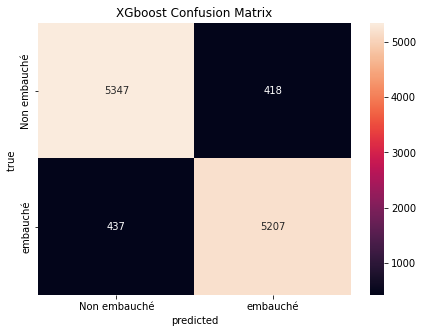

In [78]:
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(xgb_cfmat, 
            xticklabels=['Non embauché', 'embauché'],
            yticklabels=['Non embauché', 'embauché'],
            annot=True,
            fmt='g')
plt.xlabel('predicted')
plt.ylabel('true ')
plt.title('XGboost Confusion Matrix')


In [79]:
knn_ = KNeighborsClassifier(algorithm='auto', n_jobs = -1)

parameters = {
    'n_neighbors':[3,4,5],
    'weights' : ['uniform', 'distance'],
    'p' : [1,2]
}

knn = tunning(parameters,knn_, X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best Score: 0.9593958267653504
Best params: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


In [80]:
preds2 = knn.predict(X_test)
print("Tuned KNN results:")
print("Precision: " + str(round(skm.precision_score(y_true=y_test,y_pred=preds2,average='weighted') * 100, 2)) + "%")
print("Recall:    " + str(round(skm.recall_score(y_true=y_test,y_pred=preds2,average='weighted') * 100, 2)) + "%")
print("F1-Score:  " + str(round(skm.f1_score(y_true=y_test,y_pred=preds2,average='weighted') * 100, 2)) + "%")

Tuned KNN results:
Precision: 90.67%
Recall:    90.14%
F1-Score:  90.11%


In [81]:
knn_cfmat = skm.confusion_matrix(
    y_true=y_test,
    y_pred=preds2)

Text(0.5, 1.0, 'KNN Confusion Matrix')

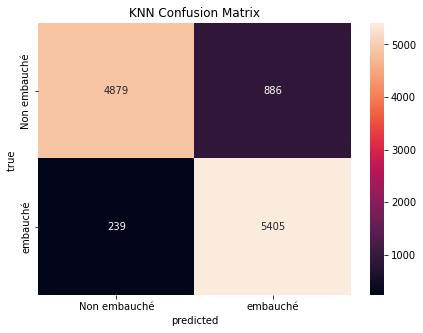

In [82]:
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(knn_cfmat, 
            xticklabels=['Non embauché', 'embauché'],
            yticklabels=['Non embauché', 'embauché'],
            annot=True,
            fmt='g')
plt.xlabel('predicted')
plt.ylabel('true ')
plt.title('KNN Confusion Matrix')


## selection des variables :

In [83]:
kbest = SelectKBest(score_func=f_classif, k='all') #Score_func peut avoir : f_classif, chi2
fit = kbest.fit(X_train, y_train.values.ravel())

In [84]:
np.set_printoptions(precision=3) #Chaque score correspond à une variable, on prend celles qui ont le meilleur score
best = { label: value for label, value in zip(FEATURES, fit.scores_) }
best

{'age': 102.66978735428029,
 'cheveux': 686.24349919758,
 'date': 14.085543064164165,
 'day': 57.829454184957115,
 'diplome': 81.7809010990038,
 'dispo': 860.8796085611799,
 'exp': 85.77409157584539,
 'month': 1.099477383725821,
 'note': 0.8261294007799663,
 'q_age': 1264.2689168022036,
 'q_exp': 914.0696570409095,
 'q_note': 349.9231040412868,
 'q_salaire': 399.46173513678815,
 'salaire': 0.18702635613603513,
 'sexe': 373.6764769521184,
 'specialite': 785.2361509343156,
 'year': 10.97462208258488}

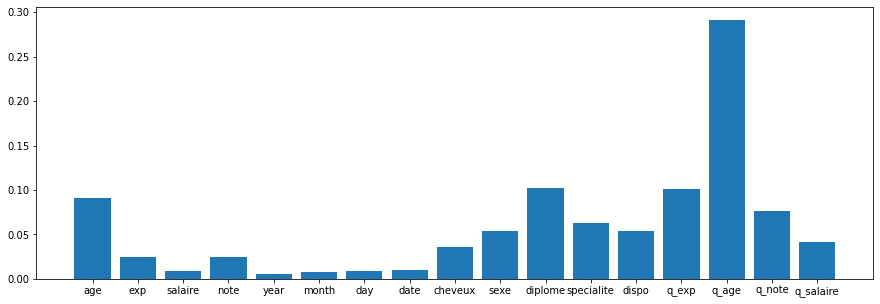

In [88]:
importance = xgb.feature_importances_
plt.figure(figsize=(15,5))
plt.bar(FEATURES,importance)
plt.show()

## Amélioration des modèles :     
- On peut utiliser HalvingGridSearchCV pour le tunning qui est plus rapide et donne les memes resultats.
- L'utilisation de plusieurs modèle de classification ( Random Forest, Gradient boosting, Decision Tree, SVC...)
- La méthode de séparationd es train/test data.